# Reproducing figures from paper

This notebook reproduces the main figures from the paper "Efficient Probabilistic Tensor Networks". 

**Model name mappings:**
- `mps_sigma_lsf` → $\mathrm{MPS}_{\sigma+\mathrm{LSF}}$ (Non-negative MPS with logarithmic scale factors)
- `mps_sigma_sgd` → $\mathrm{MPS}_{\mathrm{BM+SGD}}$ (Non-negative MPS with standard SGD)
- `mps_bm_lsf` → $\mathrm{MPS}_{\mathrm{BM+LSF}}$ (Born machine with logarithmic scale factors))  
- `mps_bm_sgd` → $\mathrm{MPS}_{\mathrm{BM+SGD}}$ (Born machine with with standard SGD)
- `mps_bm_dmrg` → $\mathrm{MPS}_{\mathrm{BM+DMRG}}$ (Born machine wit DMRG)

## Figure 1: Profiling LSF, SGD & DMRG

#### Memory, Latency & Instability

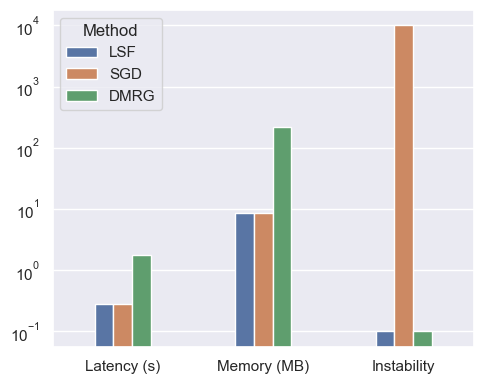

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Latency:
# >> python scripts/profile_latency.py --horizons 128 --d_output 8 --models mps_bm_dmrg mps_bm_lsf --device cpu
#     latency         name   R    H  Do  Di   B sweep_type  sweep_value                                                                                                                                                  
# 0  1.799973  mps_bm_dmrg  32  128   8   1  32          H          128
# 1  0.283370   mps_bm_lsf  32  128   8   1  32          H          128

# Memory:
# >> python scripts/profile_memory.py --d_outputs 1024 --models mps_bm_dmrg mps_bm_lsf
#          model     d      mem_mb
# 0  mps_bm_dmrg  1024  217.106445
# 1   mps_bm_lsf  1024    8.676270

# Instability:
# >> python scripts/profile_instability.py --horizons 100
#         name   horizon   iters
# 0  mps_bm_lsf      100  10000
# 1  mps_bm_sgd      100      1
sns.set_theme()

instability_fn = lambda N: 10000 - N + 0.1

# Data
df_latency_mem = pd.DataFrame({
    "Method": [r"LSF", r"SGD", r"DMRG"],
    "Latency (s)": [0.28, 0.28, 1.8], # SGD and LSF have same latency
    "Memory (MB)": [8.7, 8.7, 217],
    "Instability": [instability_fn(10000), instability_fn(1), instability_fn(10000)],
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df_latency_mem.melt(id_vars="Method", var_name="Metric", value_name="Value")

plt.figure(figsize=(5, 4))  # smaller width
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Method",
    width=0.4 
)
plt.yscale("log")
ax = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

## Figure 3: Stability analysis (Part I)

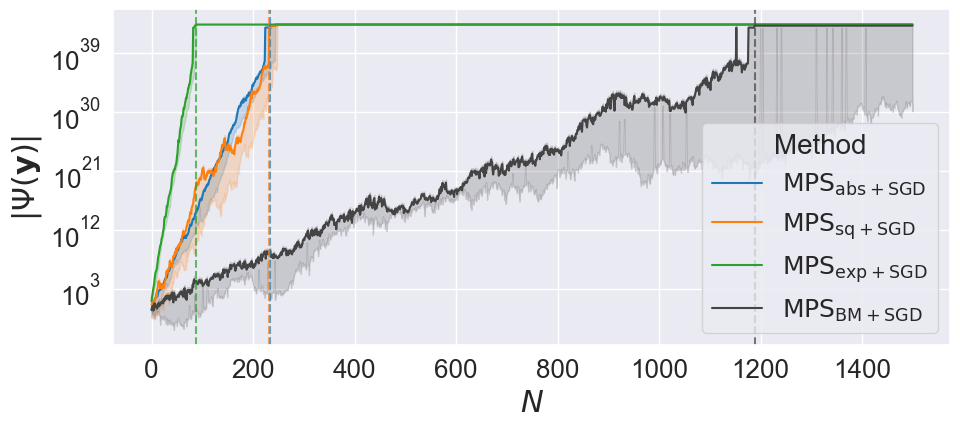

In [5]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from collections import OrderedDict

torch.manual_seed(42); np.random.seed(42)

EXPS = [
    (r"$\mathrm{MPS}_\mathrm{abs+SGD}$",     lambda W: W.abs(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{sq+SGD}$",       lambda W: W.square(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{exp+SGD}$",  lambda W: W.exp(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{BM+SGD}$",         lambda W: W, lambda py: py),  # special case
]

T, D = 1500, 2
rows, inf_at = [], {}

for seed in [0, 42, 84]:
    for name, fn, py_fn in EXPS:
        alpha, beta, hit = fn(torch.randn(D)), fn(torch.randn(D)), False
        for t in range(T):
            if not hit:
                beta = torch.mv(fn(torch.randn(D, D)), beta)
                hit = not torch.isfinite(beta).all()
                if hit: inf_at[name] = t
            psi = float("inf") if hit else float(py_fn(torch.dot(alpha, beta)))
            rows.append({"Step": t, "Method": name, "psi": abs(psi)})

df = pd.DataFrame(rows)
finite = df[np.isfinite(df["psi"])]["psi"]
cap = (finite.max() if not finite.empty else 1.0) * 1e5
df["psi"] = df["psi"].replace([np.inf], cap)

# Build custom palette: softer black (dark gray) for "None"
base_colors = sns.color_palette("tab10", len(EXPS))
palette = {name: base_colors[i] for i, (name, _, _) in enumerate(EXPS)}
palette["$\mathrm{MPS}_\mathrm{BM+SGD}$"] = "#444444"   

# Increase font size for all elements
sns.set_theme(
    font_scale=1.7,
    rc={
        "axes.labelsize": 22,
        "axes.titlesize": 24,
        # "xtick.labelsize": 18,
        # "ytick.labelsize": 18,
        "legend.fontsize": 18,
        "legend.title_fontsize": 20,
    }
)
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(data=df, x="Step", y="psi", hue="Method", palette=palette, ax=ax)
plt.yscale("log")
plt.xlabel("$N$", fontsize=22)
plt.ylabel(r"$|\Psi(\mathbf{y})|$", fontsize=22)
# vertical lines for inf
for (name, _, _), color in zip(EXPS, [palette[n] for n, _, _ in EXPS]):
    if name in inf_at:
        plt.axvline(inf_at[name], color=color, ls="--", alpha=0.7, label=f"{name} inf@{inf_at[name]}")

# dedupe legend
h, l = ax.get_legend_handles_labels()
uniq = OrderedDict(zip(l, h))

plt.tight_layout(pad=0)  # Remove extra whitespace
plt.subplots_adjust(left=0.05, right=0.98, top=0.97, bottom=0.13)  # Fine-tune to remove whitespace
plt.show()


## Figure 5: Stability analysis (Part II)

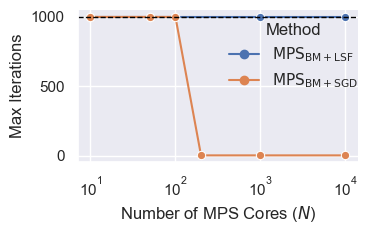

In [8]:
# Plot max iterations achieved by different methods and horizons
# plt.figure(figsize=(2,1.2))  # make figure shorter
sns.set_theme()

# Instability:
# >>> python scripts/profile_instability.py --horizons 10 50 100 200 1000 10000
#          name  horizon  iters
# 0  mps_bm_lsf       10   1000
# 1  mps_bm_lsf      100   1000
# 2  mps_bm_lsf      200   1000
# 3  mps_bm_lsf     1000   1000
# 4  mps_bm_lsf    10000   1000
# 5  mps_bm_sgd       10   1000
# 6  mps_bm_sgd      100   1000
# 7  mps_bm_sgd      200      1
# 8  mps_bm_sgd     1000      1
# 9  mps_bm_sgd    10000      1

# create df
df = pd.DataFrame(
    [
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 10, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 50, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 100, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 1000, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 10000, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 10, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 50, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 100, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 200, "iters": 1},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 1000, "iters": 1},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 10000, "iters": 1},
    ]
)

df["Method"] = df["name"]

# Rename columns for plotting
df = df.rename(columns={
    "iters": "Max Iterations",
    "horizon": "Number of MPS Cores ($N$)",
})
g = sns.relplot(
    data=df,
    x="Number of MPS Cores ($N$)",
    y="Max Iterations",
    hue="Method",
    kind="line",
    marker="o",       # one style only
    dashes=False,
    height=2.5,       # make relplot figure shorter
)
g.ax.set_xscale("log")

# Horizontal reference line
g.ax.axhline(1000, color="black", linestyle="--", linewidth=1)
g._legend.set_loc("upper right")
g._legend.set_bbox_to_anchor((0.95, 0.9))   # inset a little

plt.tight_layout()
plt.show()


## Figure 6: Latency Analysis

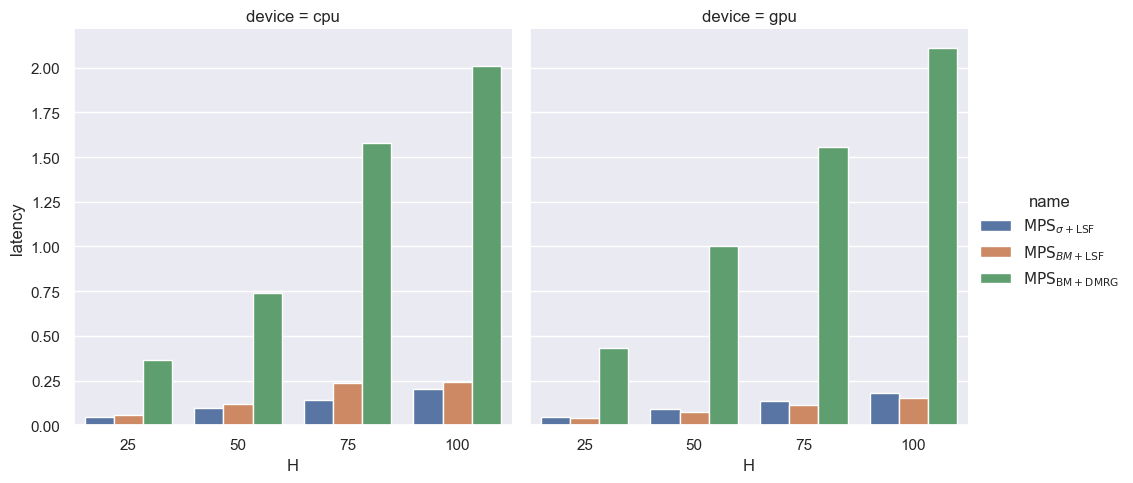

In [ ]:
# Latency results:
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg --device cpu --out results/latency_sweep_cpu.csv
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg --device gpu --out results/latency_sweep_gpu.csv

df_cpu = pd.read_csv("../results/latency_sweep_cpu.csv")
df_gpu = pd.read_csv("../results/latency_sweep_gpu.csv")
df_cpu['device'] = 'cpu'
df_gpu['device'] = 'gpu'
df = pd.concat([df_cpu, df_gpu])

# Rename methods
df['name'] = df['name'].replace({
    'mps_sigma_lsf': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'mps_bm_lsf': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'mps_bm_dmrg': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})

sns.set_theme()
sns.catplot(
    data=df,
    x="H",
    y="latency",
    hue="name",
    col="device",
    kind="bar"
)


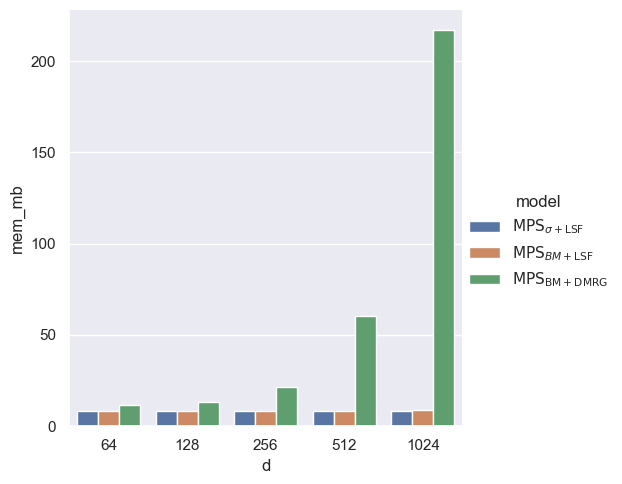

In [ ]:
# Memory results:
# >> python scripts/profile_memory.py --d_outputs 64 128 256 512 1024 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg

df_memory = pd.read_csv("../results/memory_sweep.csv")

# Rename methods
df_memory['model'] = df_memory['model'].replace({
    'mps_sigma_lsf': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'mps_bm_lsf': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'mps_bm_dmrg': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})

sns.set_theme()
sns.catplot(
    data=df_memory,
    x="d",
    y="mem_mb",
    hue="model",
    kind="bar"
)